In [1]:
import numpy as np
import scienceplots
import lovelyplots

# # Define the normalized prefactors from the table
# intra_prefactors = {
#     "qubit-qubit": 1.0,
#     "snail-qubit": 10.0,
#     "snail-qubit-sub": 0.067,
#     "qubit-sub-1/2": 10.0,
#     "qubit-sub-1/3": 0.044,
#     "snail-sub-1/2": 100.0,
#     "snail-sub-1/3": 0.018,
# }

# inter_prefactors = {
#     "qubit-qubit_1": 0.01,  # one overlapping qubit
#     "qubit-qubit_0": 0.0001,  # neither overlapping qubits
#     "snail-qubit_1": 0.1,  # one overlapping qubit
#     "snail-qubit_0": 0.001,  # neither overlapping qubits
#     "qubit-sub-1/2": 0.1,  # not overlapping qubit
#     "snail-sub-1/2": 1.0,
# }

# prefactors_bare = {
#     "qubit-resonance": 3.5,
#     "snail-resonance": 1.4,
# }


# Device parameters
# n_s = 3
lambdaq = 0.08
eta = 1.8
alpha = 120e6  # 120 MHz
N_q = 4
g3 = 60e6  # Coupling strength g3 = 60 MHz

# Define the normalized prefactors from the table
intra_prefactors = {
    "qubit-qubit": 6 * eta * lambdaq**2 * g3,  # qubit-qubit conversion
    "snail-qubit": 6 * eta * lambdaq * g3,  # snail-qubit conversion
    "snail-qubit-sub": alpha * eta**2 * lambdaq**3,  # snail-qubit sub conv
    "qubit-sub-1/2": 3 * eta**2 * lambdaq * g3,  # qubit sub harmonic (1/2)
    "qubit-sub-1/3": alpha * eta**3 * lambdaq**3 / 3,  # qubit sub harmonic (1/3)
    "snail-sub-1/2": 3 * eta**2 * g3,  # snail sub harmonic (1/2)
    "snail-sub-1/3": N_q * alpha * eta**3 * lambdaq**4 / 3,  # snail sub harmonic (1/3)
}

inter_prefactors = {
    "qubit-qubit_1": 6 * eta * lambdaq**4 * g3,  # qubit-qubit conversion (overlapping)
    "qubit-qubit_0": 6 * eta * lambdaq**6 * g3,  # qubit-qubit conversion (non)
    "snail-qubit_1": 6 * eta * lambdaq**3 * g3,  # snail-qubit conversion (overlapping)
    "snail-qubit_0": 6 * eta * lambdaq**5 * g3,  # snail-qubit conversion (non)
    "qubit-sub-1/2": 3 * eta**2 * lambdaq**3 * g3,  # qubit sub harmonic (non)
    "snail-sub-1/2": 3 * eta**2 * g3 * lambdaq**2,  # snail sub harmonic (neighbor)
}

prefactors_bare = {
    "qubit-resonance": sum(
        [alpha * eta**3 * lambdaq**3, alpha * eta * lambdaq**3, alpha * eta * lambdaq]
    ),
    "snail-resonance": 4 * alpha * eta**3 * lambdaq**4
    + 4 * alpha * eta * lambdaq**4
    + 4 * alpha * eta * lambdaq**2,
}


prefactors = {}
prefactors.update(intra_prefactors)
# prefactors.update(inter_prefactors)
prefactors.update(prefactors_bare)

# without normalization, I need t_f = 218 nanoseconds
# with 6 eta lambda^2 g3 = 1.0 -> then t_f = pi/2 (iswap)

In [2]:
def calculate_module_interactions(bare_frequencies, snail_frequency):
    interactions = {
        "qubit-qubit": [],
        "snail-qubit": [],
        "snail-qubit-sub": [],
        "qubit-sub-1/2": [],
        "qubit-sub-1/3": [],
        "snail-sub-1/2": [],
        "snail-sub-1/3": [],
        "qubit-resonance": bare_frequencies,  # Bare frequencies for qubit resonance
        "snail-resonance": [snail_frequency],  # Bare frequency for snail resonance
    }

    # Calculate qubit-qubit interactions (pairwise differences)
    for i, freq1 in enumerate(bare_frequencies):
        for freq2 in bare_frequencies[i + 1 :]:
            interactions["qubit-qubit"].append(abs(freq1 - freq2))

    # Calculate snail-qubit interactions
    for freq in bare_frequencies:
        interactions["snail-qubit"].append(abs(freq - snail_frequency))
        interactions["snail-qubit-sub"].append(abs(freq - snail_frequency) / 2)

    # Calculate sub-harmonics
    for freq in bare_frequencies:
        if "qubit-sub-1/2" in interactions:
            interactions["qubit-sub-1/2"].append(freq / 2)
        if "qubit-sub-1/3" in interactions:
            interactions["qubit-sub-1/3"].append(freq / 3)

    if "snail-sub-1/2" in interactions:
        interactions["snail-sub-1/2"].append(snail_frequency / 2)
    if "snail-sub-1/3" in interactions:
        interactions["snail-sub-1/3"].append(snail_frequency / 3)

    return interactions

In [10]:
# Fitted infidelity vs amplitude functions
def infidelity_power_law(amplitude, a, b):
    return a * amplitude**b


def _unit_crosstalk(intended_freq, spectator_key, spectator_freq):
    distance = np.abs(intended_freq - spectator_freq)
    units_distance = distance * 1e9  # Convert to a suitable scale, e.g., Hz to GHz

    # Select the correct parameters based on interaction type
    if "sub" in spectator_key:
        a, b = 1.752, 1.971  # Parameters for subharmonic interactions
    else:
        a, b = 1.101, 1.979  # Parameters for direct conversion interactions

    weight = prefactors[spectator_key]
    if units_distance == 0:
        ampl = 10
    else:
        ampl = 2 * weight / units_distance

    return infidelity_power_law(ampl, a, b)


def cost_function(bare_frequencies, snail_frequency):
    interactions = calculate_module_interactions(bare_frequencies, snail_frequency)

    # # distance with respect to driven terms
    # driven_terms = ["qubit-qubit", "qubit-resonance"]

    # bare mode separation (we need single-qubit gates to still be addressable)
    # and not included in this model are many "always-on" interactions terms
    # this will be non-neglible provided the bare frequencies are too close
    bare_term_cost = 0
    for i, bare_mode in enumerate(interactions["qubit-resonance"]):
        bare_term_cost += _unit_crosstalk(bare_mode, "snail-resonance", snail_frequency)
        for j, other_qubit in enumerate(interactions["qubit-resonance"]):
            if i != j:
                bare_term_cost += _unit_crosstalk(
                    bare_mode, "qubit-resonance", other_qubit
                )

    two_qubit_gate_cost = 0
    for i, freqi in enumerate(interactions["qubit-qubit"]):
        for freq_type in interactions.keys():
            for j, freqj in enumerate(interactions[freq_type]):
                if (freq_type != "qubit-qubit") or (i != j):
                    two_qubit_gate_cost += _unit_crosstalk(freqi, freq_type, freqj)
    return bare_term_cost + two_qubit_gate_cost
    # return two_qubit_gate_cost

In [4]:
import matplotlib.pyplot as plt
import numpy as np  # Assuming it's used elsewhere in your code


def plot_frequencies(bare_frequencies, snail_frequency):
    """Plot the bare qubit frequencies, SNAIL frequency, and calculated interaction frequencies
    based on the calculate_interactions helper function.
    """
    # Calculate interaction frequencies using helper function
    interactions = calculate_module_interactions(bare_frequencies, snail_frequency)

    # Set up plot
    with plt.style.context(["ieee", "use_mathtext", "science"]):
        fig, ax = plt.subplots(figsize=(3.5, 1))
        max_freq = max(np.append(bare_frequencies, snail_frequency)) * 1.1
        ax.set_xlim(0, max_freq)
        ax.get_yaxis().set_visible(False)

        # Plot interactions with color-coding by type
        for interaction_type, freqs in interactions.items():
            color = {
                "qubit-qubit": "blue",
                "qubit-resonance": "green",
                "snail-qubit": "teal",
                "snail-qubit-sub": "orange",
                "qubit-sub-1/2": "purple",
                "qubit-sub-1/3": "cyan",
                "snail-sub-1/2": "magenta",
                "snail-sub-1/3": "pink",
                "snail-resonance": "red",
            }.get(interaction_type, "black")

            linestyle = (
                (0, (0.2, 0.4))
                if interaction_type
                in ["snail-qubit-sub", "qubit-sub-1/3", "snail-sub-1/3"]
                else "-"
            )

            for freq in freqs:
                ax.axvline(
                    freq,
                    color=color,
                    linestyle=linestyle,
                    linewidth=2,
                    alpha=0.8,
                    label=interaction_type.replace("-", " ").title(),
                )

        ax.set_xlabel("Frequency (GHz)")
        # ax.legend()

    plt.show()

In [5]:
# use scipy minimize for N_attempts random initializations
from scipy.optimize import minimize
from tqdm.notebook import tqdm


def optimize_layout(
    N_qubits=4, qubit_bounds=(3.3, 5.7), snail_bounds=(4.2, 4.7), N_attempts=128
):
    best_cost = np.inf
    best_freqs = None
    best_snail = None

    for _ in tqdm(range(N_attempts)):
        # Randomly initialize qubit frequencies and SNAIL frequency
        bare_frequencies = np.random.uniform(qubit_bounds[0], qubit_bounds[1], N_qubits)
        snail_frequency = np.random.uniform(snail_bounds[0], snail_bounds[1])

        # Minimize the cost function
        result = minimize(
            lambda x: cost_function(x[:-1], x[-1]),
            x0=np.append(bare_frequencies, snail_frequency),
            bounds=[qubit_bounds] * N_qubits + [snail_bounds],
            # method="L-BFGS-B",
        )

        # Update best cost and frequencies if new minimum found
        if result.fun < best_cost:
            print("improved:", result.fun)
            best_cost = result.fun
            best_freqs = result.x[:-1]
            best_snail = result.x[-1]

    print(f"Best cost: {best_cost}")
    print(f"Best qubit frequencies: {best_freqs}")
    print(f"Best SNAIL frequency: {best_snail}")
    return best_freqs, best_snail

  0%|          | 0/128 [00:00<?, ?it/s]

improved: 0.6556384507877192
improved: 0.6320387949118245
improved: 0.6320387949118238
improved: 0.6320387949118236
Best cost: 0.6320387949118236
Best qubit frequencies: [3.51479565 3.3       ]
Best SNAIL frequency: 4.7


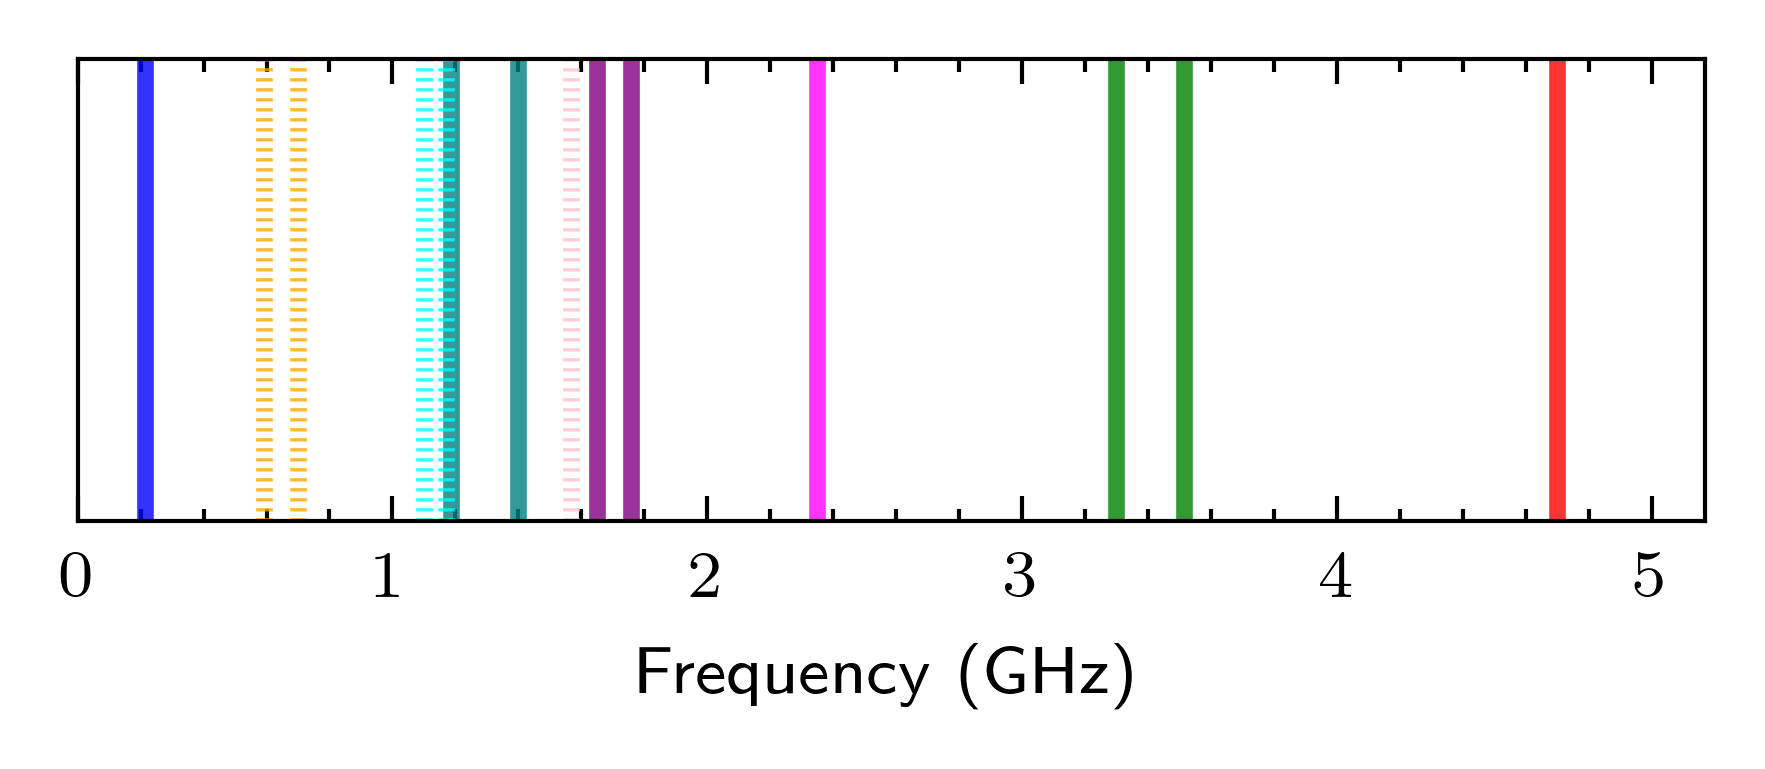

In [11]:
best_freqs2, best_snail2 = optimize_layout(N_qubits=2)
plot_frequencies(best_freqs2, best_snail2)

  0%|          | 0/128 [00:00<?, ?it/s]

improved: 2.10150750143153
improved: 2.1015075014257047
improved: 2.1015075014254316
Best cost: 2.1015075014254316
Best qubit frequencies: [3.44077281 3.3        3.65564272]
Best SNAIL frequency: 4.7


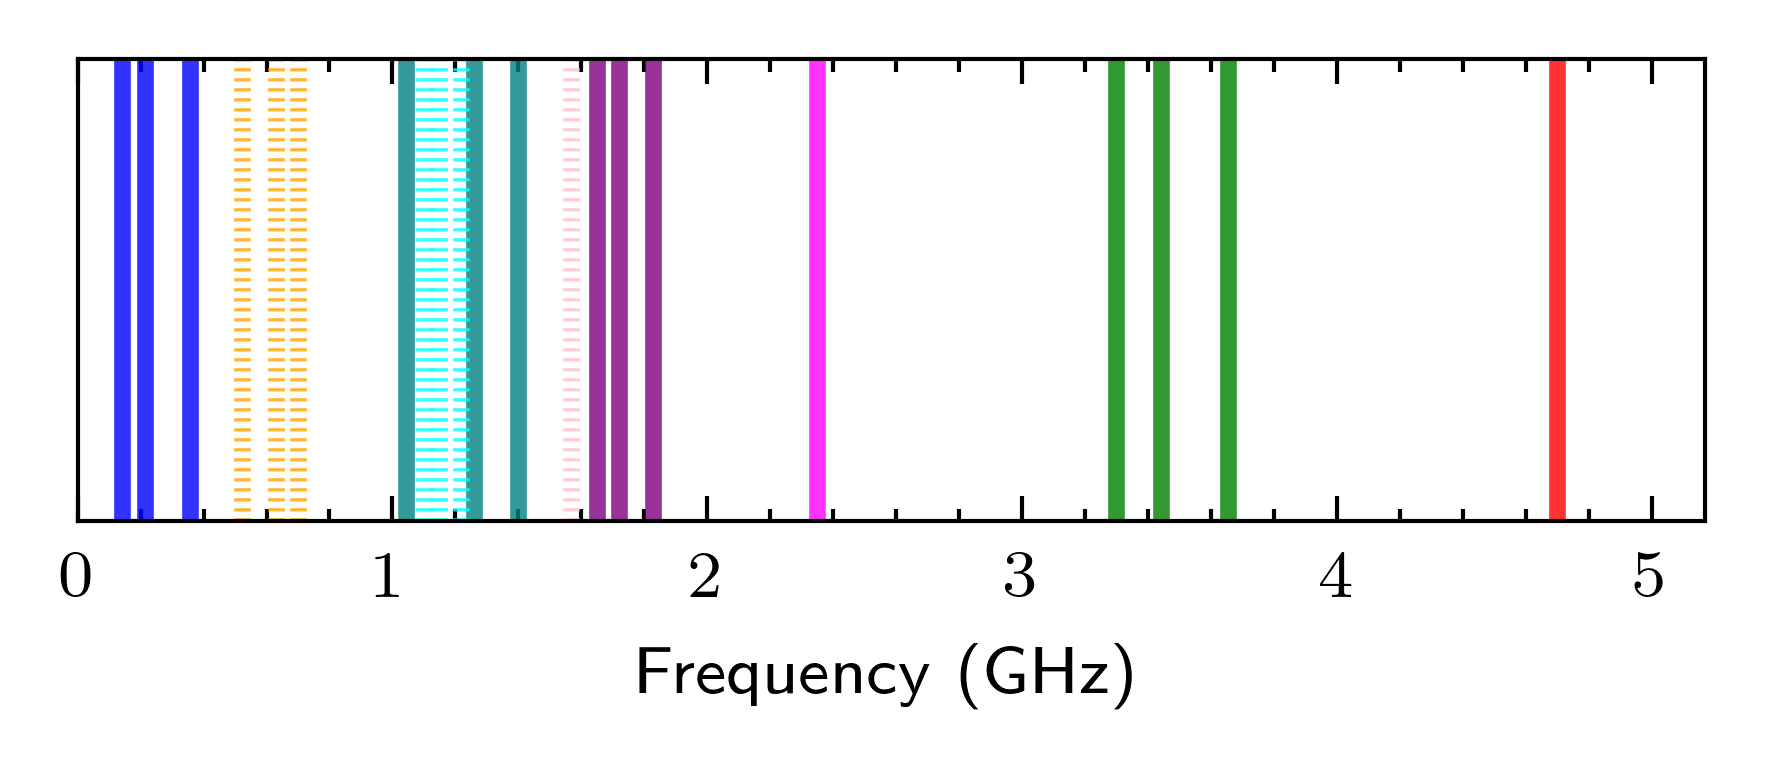

In [12]:
best_freqs3, best_snail3 = optimize_layout(N_qubits=3)
plot_frequencies(best_freqs3, best_snail3)

  0%|          | 0/128 [00:00<?, ?it/s]

improved: 12.945742799931919
improved: 10.405639391279909
improved: 5.792145860513375
Best cost: 5.792145860513375
Best qubit frequencies: [3.78117259 3.56458237 3.63972176 3.90276482]
Best SNAIL frequency: 4.618167822906562


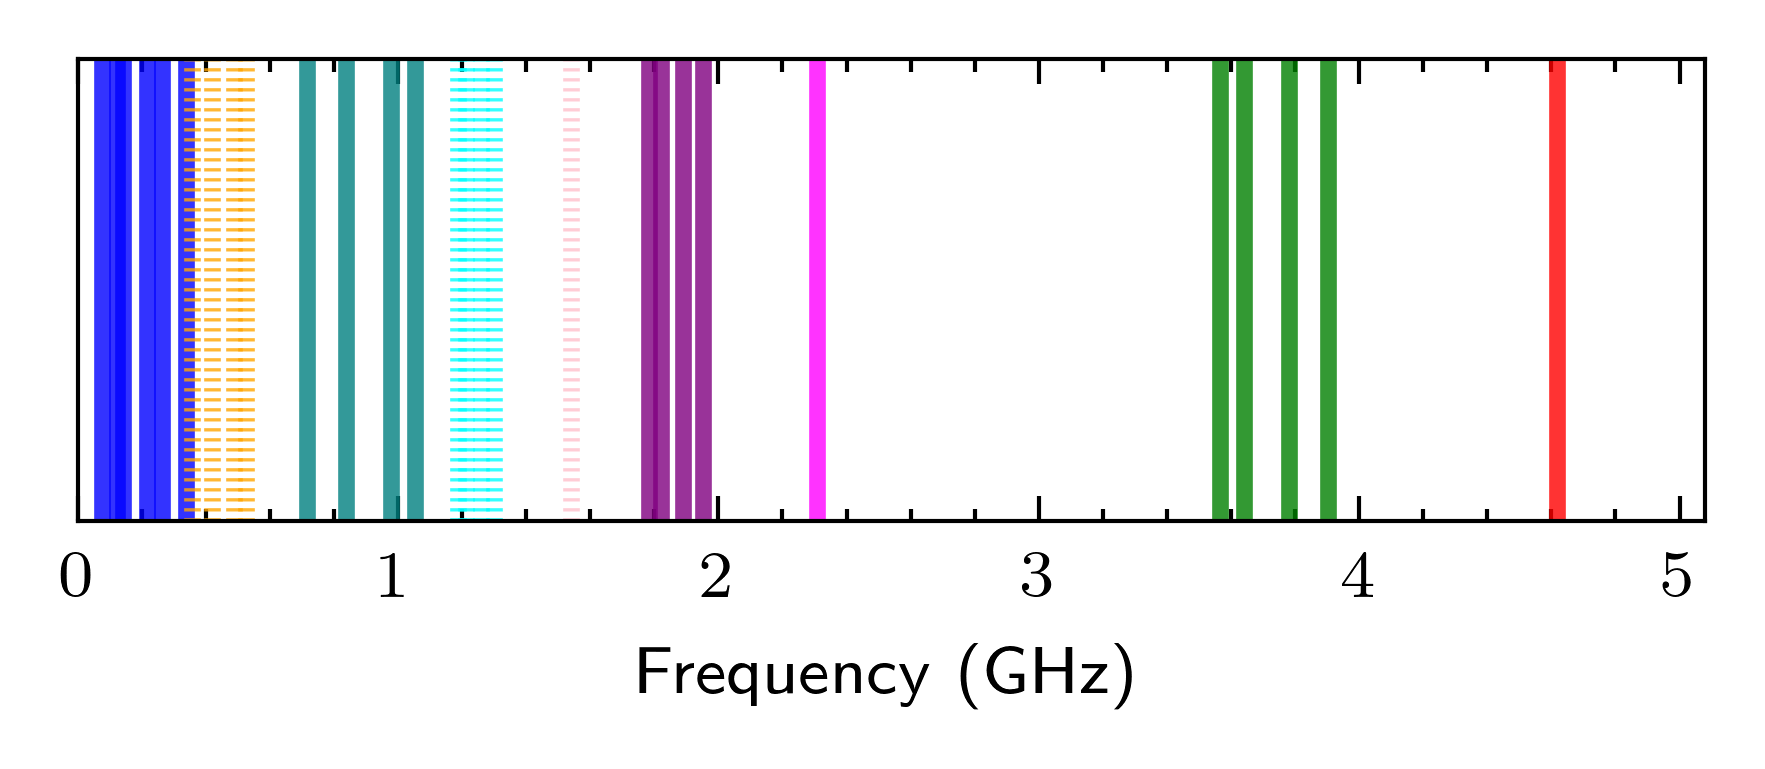

In [13]:
best_freqs4, best_snail4 = optimize_layout(N_qubits=4)
plot_frequencies(best_freqs4, best_snail4)

  0%|          | 0/128 [00:00<?, ?it/s]

improved: 517.2329670346827
improved: 21.65633983949067
improved: 21.627279698452273
improved: 15.775267761828774
Best cost: 15.775267761828774
Best qubit frequencies: [3.39618146 3.3        4.32371582 4.13027242 4.26207828]
Best SNAIL frequency: 4.7


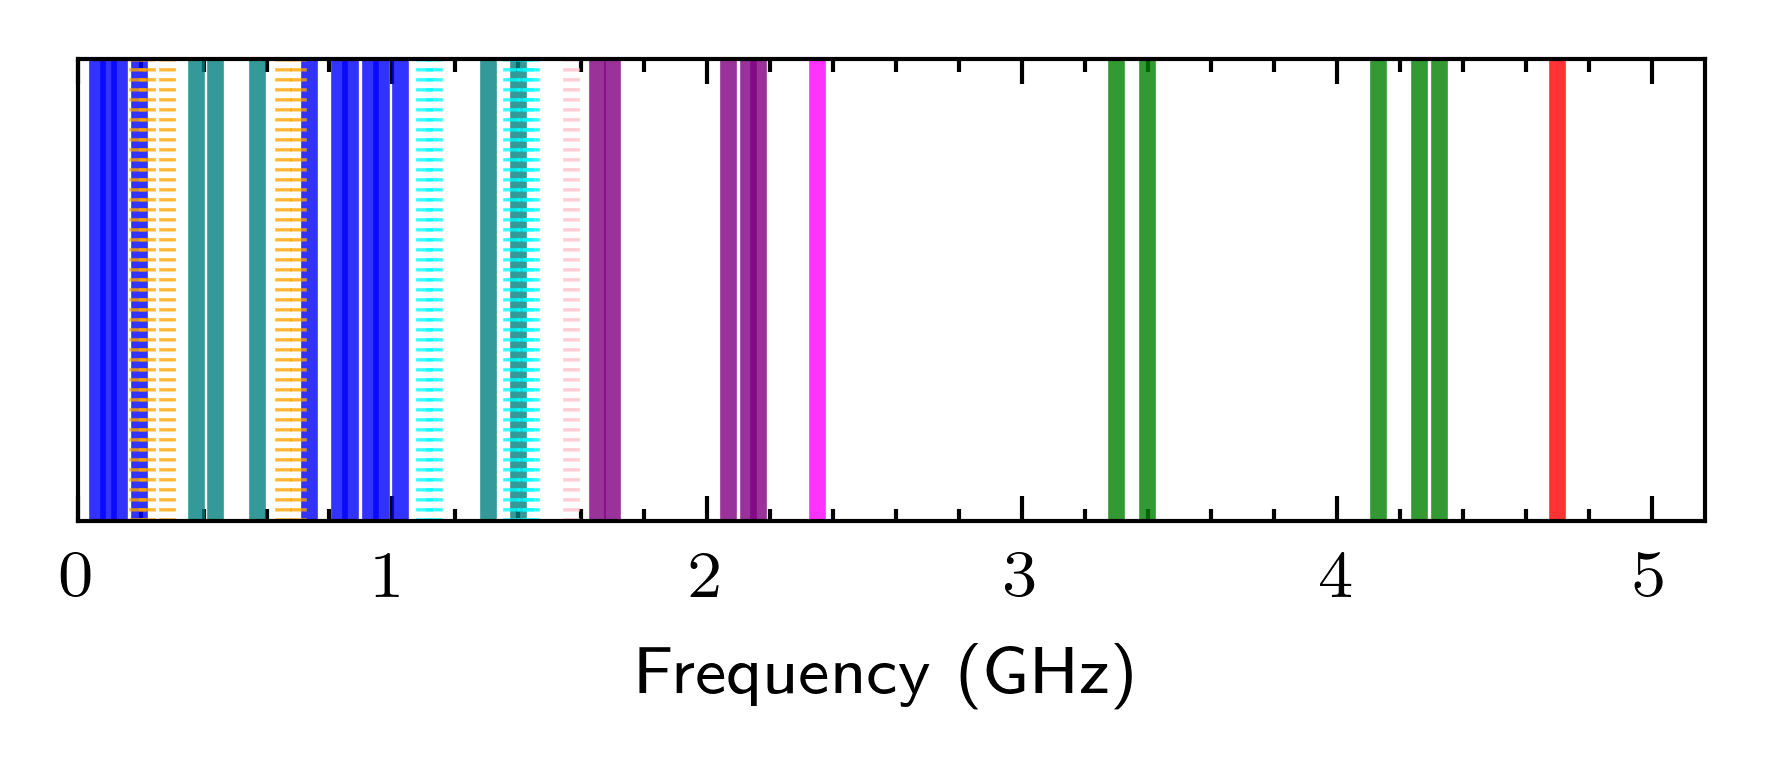

In [14]:
best_freqs5, best_snail5 = optimize_layout(N_qubits=5)
plot_frequencies(best_freqs5, best_snail5)

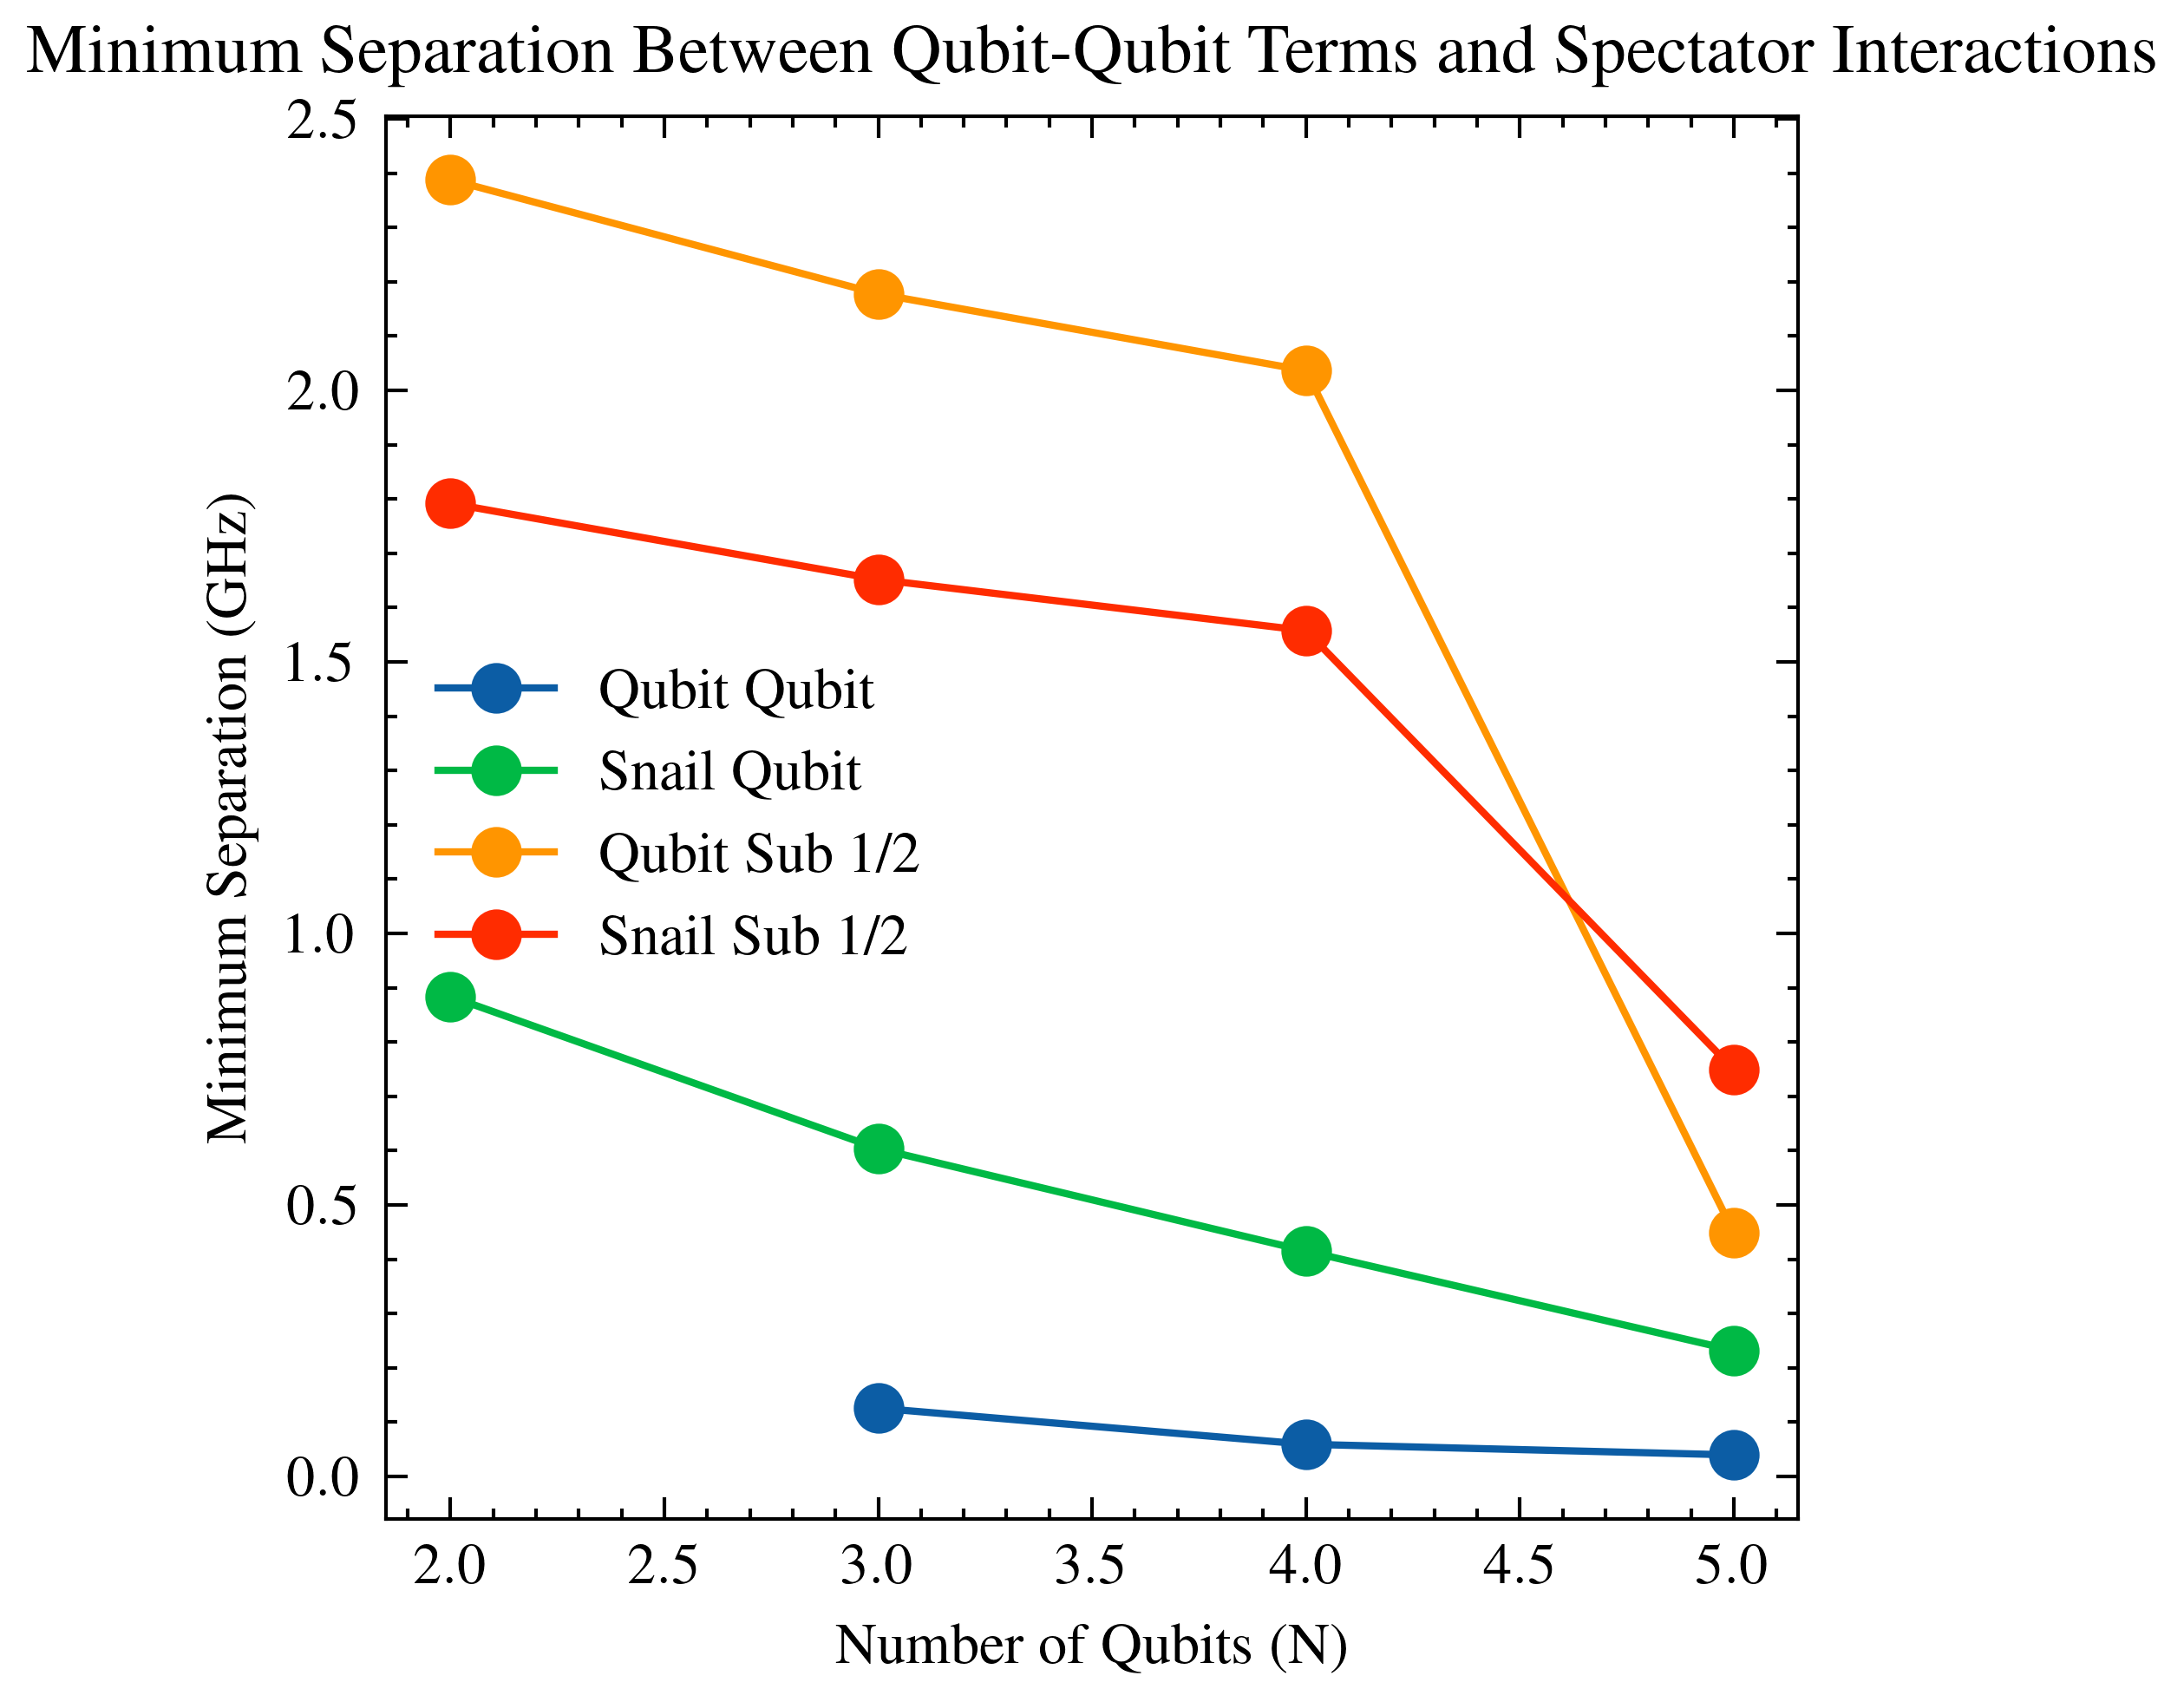

In [19]:
def plot_minimum_separations_with_qubit(N_values=[2, 3, 4, 5]):
    """Plot the minimum separation between a 'qubit-qubit' term and each spectator interaction type
    for N = 2 through N = 5, including qubit-qubit as a spectator to other qubit-qubit terms.
    """
    # Define interaction types to consider as spectators
    spectator_types = [
        "qubit-qubit",
        "snail-qubit",
        "qubit-sub-1/2",
        "snail-sub-1/2",
    ]

    # Dictionary to store minimum separations for each N and each spectator type
    min_separations = {spec_type: [] for spec_type in spectator_types}

    # Mapping from N to the respective best_freqs and best_snail variables
    best_freqs_map = {
        2: (best_freqs2, best_snail2),
        3: (best_freqs3, best_snail3),
        4: (best_freqs4, best_snail4),
        5: (best_freqs5, best_snail5),
    }

    # Calculate minimum separations for each N
    for N in N_values:
        # Get optimized frequencies for current N
        best_freqs, best_snail = best_freqs_map[N]
        interactions = calculate_module_interactions(best_freqs, best_snail)

        # Calculate minimum separation between 'qubit-qubit' terms and each spectator type
        for spec_type in spectator_types:
            min_separation = float("inf")

            # Skip 'qubit-qubit' as a spectator for N=2
            if spec_type == "qubit-qubit" and N == 2:
                min_separations[spec_type].append(None)  # Placeholder for N=2
                continue

            for i, qq_freq in enumerate(interactions["qubit-qubit"]):
                for j, freq in enumerate(interactions[spec_type]):
                    # Avoid self-comparison in qubit-qubit interactions
                    if spec_type == "qubit-qubit" and i == j:
                        continue
                    separation = abs(qq_freq - freq)
                    if separation < min_separation:
                        min_separation = separation
            if min_separation != float("inf"):
                min_separations[spec_type].append(min_separation)

    # Plot minimum separations for each spectator type across different N values
    with plt.style.context(["ieee", "use_mathtext", "science"]):
        fig, ax = plt.subplots(figsize=(3.5, 3.5))
        for spec_type, separations in min_separations.items():
            ax.plot(
                N_values,
                separations,
                marker="o",
                label=spec_type.replace("-", " ").title(),
            )

        ax.set_xlabel("Number of Qubits (N)")
        ax.set_ylabel("Minimum Separation (GHz)")
        ax.set_title(
            "Minimum Separation Between Qubit-Qubit Terms and Spectator Interactions"
        )
        ax.legend()
        plt.show()
        # set x-ticks only on integers
        ax.set_xticks(N_values, minor=False)


# Call the function to plot
plot_minimum_separations_with_qubit(N_values=[2, 3, 4, 5])

In [20]:
# best_freqs6, best_snail6 = optimize_layout(N_qubits=6)
# plot_frequencies(best_freqs6, best_snail6)

In [21]:
# from matplotlib import pyplot as plt

# # plot min_spacing and avg_spacing as a function of num_qubits
# min_spacings = []
# avg_spacings = []
# num_qubits = list(range(2, 8))
# for n in num_qubits:
#     allocator = FrequencyAllocator(num_qubits=n)
#     min_spacings.append(allocator.min_spacing)
#     avg_spacings.append(allocator.avg_spacing)

# fig, ax = plt.subplots()
# ax.plot(num_qubits, min_spacings, label="Minimum Spacing", marker="o")
# ax.plot(num_qubits, avg_spacings, label="Average Spacing", marker="x")
# ax.set_xlabel("Number of Qubits")
# ax.set_ylabel("Spacing (GHz)")
# ax.set_title("Spacing vs. Number of Qubits")
# ax.legend()
# plt.show()

In [22]:
# exp_term = [w - wp for w in allocator.all_interactions]
# # keep the 3 smallest absolute values
# values = np.argsort(np.abs(exp_term))[:3]
# # from these values, index back into the original list
# values = [allocator.all_interactions[value] for value in values]

# for value in values:
#     if value in allocator.qubit_qubit_interactions:
#         print(allocator.qubit_qubit_interactions[value])
#         index = list(allocator.qubit_qubit_interactions.keys()).index(value)
#         print(exp_term[index])
#     elif value in allocator.qubit_snail_interactions:
#         print(allocator.qubit_snail_interactions[value])
#         index = list(allocator.qubit_snail_interactions.keys()).index(value)
#         print(exp_term[index])
#     else:  # must be a bare frequency
#         print("?")
#         index = allocator.all_interactions.index(value)
#         print(exp_term[index])

In [23]:
# from quantum_logical.pulsesim import QuantumSystem, Pulse
# from quantum_logical.pulsesim.mode import QubitMode, SNAILMode

# qubits = []
# for qubit in allocator.bare_frequencies:
#     qubit = QubitMode(name=f"q{qubit}", freq=qubit, dim=2, alpha=0)
#     qubits.append(qubit)

# snail = SNAILMode(name="s", freq=allocator.snail, g3=0.3, dim=10)

# # couplings
# # _couplings = {
# #     frozenset([qubit1, snail]): 2 * np.pi * 0.05467,
# #     frozenset([qubit2, snail]): 2 * np.pi * 0.0435,
# #     frozenset([qubit3, snail]): 2 * np.pi * 0.04875,
# # }
# _couplings = {frozenset([q, snail]): 2 * np.pi * 0.05 for q in qubits}

# qs = QuantumSystem(qubits + [snail], couplings=_couplings)

In [24]:
# qs._lambda(qubits[0], qubits[1])

In [25]:
# # we are going to assume no time-dependence
# epsilon = 0.1  # ampltiude (?)
# eta = 2 * wp * epsilon / (wp**2 - allocator.snail**2)

# H_eff = 0

# for i, qubit1 in enumerate(qubits):
#     for j, qubit2 in enumerate(qubits[i + 1 :], start=i + 1):
#         wi = qs.dressed_freqs[qubit1]
#         wj = qs.dressed_freqs[qubit2]
#         temp = (
#             6
#             * qs._lambda(snail, qubit1)
#             * qs._lambda(snail, qubit2)
#             * eta
#             * qs.modes_a[qubit1]
#             * qs.modes_a_dag[qubit2]
#             * (np.exp(-1j * wi -wj + wp)
#         )

In [26]:
# import matplotlib.pyplot as plt
# from ipywidgets import interactive_output, VBox, HBox, FloatSlider, Layout
# import numpy as np

# %matplotlib widget

# # Create a figure and axes for plotting
# fig, ax = plt.subplots(figsize=(10, 2))

# # Number of qubits can be adjusted here
# num_qubits = 5

# # Create sliders for qubits and SNAIL
# sliders = {
#     f"qubit_{i}": FloatSlider(
#         value=np.random.uniform(3, 6),
#         min=0,
#         max=6,
#         description=f"Qubit {i}",
#         # orientation="vertical",
#         continuous_update=False,
#         step=0.01,
#     )
#     for i in range(num_qubits)
# }
# sliders["snail"] = FloatSlider(
#     value=4.5,
#     min=3,
#     max=7,
#     description="SNAIL",
#     # orientation="vertical",
#     continuous_update=False,
#     step=0.01,
# )


# # initialize the dictionary
# initial_frequencies = np.linspace(3, 7, num_qubits + 1)  # +1 for SNAIL
# frequency_dict = {}
# for qubit in range(num_qubits):
#     frequency_dict[f"qubit_{qubit}"] = ax.axvline(
#         initial_frequencies[qubit], color="green", linestyle="-", linewidth=3
#     )
# frequency_dict["snail"] = ax.axvline(
#     initial_frequencies[-1], color="red", linestyle="-", linewidth=2
# )

# # add frequency pairs to the dictionary (sum and difference)
# # use frozenset() to ensure that the order of the keys doesn't matter
# for i, mode1 in enumerate(initial_frequencies):
#     for j, mode2 in enumerate(initial_frequencies):
#         if i == j:
#             continue
#         key1 = f"qubit_{i}"
#         key2 = f"qubit_{j}"
#         if i == len(initial_frequencies) - 1:
#             key1 = "snail"
#         if j == len(initial_frequencies) - 1:
#             key2 = "snail"

#         freq1 = initial_frequencies[i]
#         freq2 = initial_frequencies[j]

#         sum_freq = freq1 + freq2
#         diff_freq = abs(freq1 - freq2)
#         sum_key = f"sum_{key1}_{key2}"
#         diff_key = f"diff_{key1}_{key2}"
#         # frequency_dict[sum_key] = sum_freq
#         # frequency_dict[diff_key] = diff_freq

#         alpha = 1
#         if "snail" in sum_key:
#             color = "red"
#             # transparenet
#             # alpha = 0
#         else:
#             color = "blue"

#         frequency_dict[sum_key] = ax.axvline(
#             sum_freq, color=color, linestyle="-", linewidth=3, alpha=alpha
#         )
#         frequency_dict[diff_key] = ax.axvline(
#             diff_freq, color=color, linestyle="-", linewidth=3, alpha=alpha
#         )

# # Initialize plot properties
# ax.set_xlim(0, 14)
# ax.get_yaxis().set_visible(False)
# plt.title("Qubit and SNAIL Frequencies")


# # Function to update the plot
# def update_plot(**mode_frequencies):
#     # Update the frequency lines
#     for mode, freq in mode_frequencies.items():
#         frequency_dict[mode].set_xdata([freq, freq])

#     # update the pairs
#     for key1, freq1 in mode_frequencies.items():
#         for key2, freq2 in mode_frequencies.items():
#             if key1 == key2:
#                 continue
#             sum_freq = freq1 + freq2
#             diff_freq = abs(freq1 - freq2)
#             sum_key = f"sum_{key1}_{key2}"
#             diff_key = f"diff_{key1}_{key2}"
#             frequency_dict[sum_key].set_xdata([sum_freq, sum_freq])
#             frequency_dict[diff_key].set_xdata([diff_freq, diff_freq])

#     # Redraw the figure to update the lines
#     fig.canvas.draw_idle()


# # Layout adjustments for better UI
# slider_layout = VBox(list(sliders.keys()), layout=Layout(width="400"))
# plot_layout = interactive_output(update_plot, sliders)

# # Display the interactive widgets alongside the plot
# display(HBox([slider_layout, plot_layout]))

In [27]:
# import numpy as np
# from tqdm import tqdm


# class FrequencyAllocator:
#     def __init__(self, qubit_min=4.0, qubit_max=6.0, num_qubits=2):
#         self.qubit_min = qubit_min
#         self.qubit_max = qubit_max
#         self.num_qubits = num_qubits
#         self.qubit_qubit_interactions = {}
#         self.qubit_snail_interactions = {}
#         self.bare_frequencies = [qubit_min, qubit_max]
#         self.snail = None
#         self.min_spacing = float("inf")
#         self.avg_spacing = float("inf")
#         self._update_interactions()

#         while len(self.bare_frequencies) < self.num_qubits:
#             self.add_qubit()
#         self.add_snail()

#     @property
#     def all_interactions(self):
#         return (
#             list(self.qubit_qubit_interactions.keys())
#             + list(self.qubit_snail_interactions.keys())
#             + self.bare_frequencies
#             + [self.snail]
#             + np.array(self.bare_frequencies) / 3
#         )

#     def _update_interactions(self):
#         # Reset and calculate qubit-qubit interactions.
#         self.qubit_qubit_interactions = {}
#         for i, freq1 in enumerate(self.bare_frequencies):
#             for j, freq2 in enumerate(self.bare_frequencies[i + 1 :], start=i + 1):
#                 interaction_freqs = [freq1 + freq2, abs(freq1 - freq2)]
#                 for f in interaction_freqs:
#                     if f not in self.qubit_qubit_interactions:
#                         self.qubit_qubit_interactions[f] = []
#                     self.qubit_qubit_interactions[f].append((i, j))

#     def _add_snail_interactions(self):
#         # Directly calculate and update interactions for the SNAIL with all qubits.
#         if self.snail is not None:
#             self.qubit_snail_interactions = {}
#             for i, freq in enumerate(self.bare_frequencies):
#                 interaction_freqs = [freq + self.snail, abs(freq - self.snail)]
#                 for f in interaction_freqs:
#                     if f not in self.qubit_snail_interactions:
#                         self.qubit_snail_interactions[f] = []
#                     self.qubit_snail_interactions[f].append((i, "S"))  # 'S' for SNAIL

#     def _potential_interactions(self, new_freq):
#         # Ensure SNAIL is added last as per requirements.
#         assert self.snail is None, "SNAIL should be added last."
#         # Calculate potential interactions for a new qubit frequency.
#         return [new_freq + freq for freq in self.bare_frequencies] + [
#             abs(new_freq - freq) for freq in self.bare_frequencies
#         ]

#     def _evaluate_new_frequency(self, new_freq, is_snail=False):
#         potential_interactions = self._potential_interactions(new_freq)

#         # Construct the list of all interactions, always including the new frequency and potential interactions.
#         all_interactions = (
#             self.bare_frequencies
#             + [new_freq]  # Include the new frequency for consideration.
#             + list(self.qubit_qubit_interactions.keys())
#             + potential_interactions  # Include potential new interactions.
#             + list(
#                 self.qubit_snail_interactions.keys()
#             )  # SNAIL interactions are always considered.
#         )

#         # Check for duplicates to handle the case where the new frequency exactly matches an existing frequency.
#         if len(all_interactions) != len(set(all_interactions)):
#             return 0, 0  # Return the worst score for duplicates, as specified.

#         # Sort all interactions to optimize nearest neighbor search.
#         all_interactions_sorted = sorted(all_interactions)

#         distances = []
#         # Prepare the list of frequencies to evaluate based on whether we're adding a SNAIL or not.
#         candidate_interactions = list(self.qubit_qubit_interactions.keys()) + (
#             potential_interactions if not is_snail else []
#         )

#         for base_freq in candidate_interactions:
#             # Find the position of base_freq in the sorted list to efficiently find its nearest neighbors.
#             pos = all_interactions_sorted.index(base_freq)
#             # Calculate distances to the nearest neighbors in the sorted list.
#             if pos > 0:
#                 left_distance = abs(base_freq - all_interactions_sorted[pos - 1])
#             else:
#                 left_distance = float("inf")

#             if pos < len(all_interactions_sorted) - 1:
#                 right_distance = abs(base_freq - all_interactions_sorted[pos + 1])
#             else:
#                 right_distance = float("inf")

#             # The nearest neighbor distance is the minimum of the left and right distances.
#             nearest_neighbor_distance = min(left_distance, right_distance)
#             distances.append(nearest_neighbor_distance)

#         # Calculate and return the minimum and average of the nearest neighbor distances.
#         # if distances:
#         return min(distances), sum(distances) / len(distances)

#     def _find_optimal_frequency(self, is_snail=False):
#         optimal_freq = None
#         best_min_distance = -np.inf
#         best_avg_distance = -np.inf
#         for freq in np.linspace(self.qubit_min, self.qubit_max, 1800):
#             min_distance, avg_distance = self._evaluate_new_frequency(
#                 freq, is_snail=is_snail
#             )

#             # Check if the new score is better based on min distance and then avg distance for tie-breaking.
#             if min_distance > best_min_distance or (
#                 min_distance == best_min_distance and avg_distance > best_avg_distance
#             ):
#                 best_min_distance = min_distance
#                 best_avg_distance = avg_distance
#                 optimal_freq = freq

#         # Update class attributes with the current costs.
#         self.min_spacing, self.avg_spacing = best_min_distance, best_avg_distance

#         return optimal_freq

#     def add_qubit(self):
#         # Add a new qubit with an optimal frequency and update interactions accordingly.
#         new_freq = self._find_optimal_frequency(is_snail=False)
#         self.bare_frequencies.append(new_freq)
#         self._update_interactions()

#     def add_snail(self):
#         # Ensure SNAIL tie-breaking logic is correctly handled.
#         self.snail = self._find_optimal_frequency(is_snail=True)
#         self._add_snail_interactions()

#     def __str__(self):
#         return f"Optimized Bare Frequencies: {self.bare_frequencies}\nOptimized SNAIL Frequency: {self.snail}\nMin Spacing: {self.min_spacing}\nAvg Spacing: {self.avg_spacing}"

#     def _plot(self):
#         # Plot the optimized frequencies and interactions.
#         fig, ax = plt.subplots(figsize=(16, 2))
#         height = self.qubit_max * 1.1
#         ax.set_xlim(0, height)
#         ax.get_yaxis().set_visible(False)
#         plt.title("Parametric Drive Frequencies")

#         # Plot the bare frequencies.
#         for i, freq in enumerate(self.bare_frequencies):
#             ax.axvline(freq, color="green", linestyle="-", linewidth=3)
#             ax.text(freq, freq / height, f"Q{i}", rotation=90)
#             ax.axvline(freq / 3.0, color="green", linestyle="-", linewidth=3)
#             ax.text(freq / 3.0, freq / (3.0 * height), f"Q{i}", rotation=90)

#         # Plot the SNAIL frequency.
#         ax.axvline(self.snail, color="red", linestyle="-", linewidth=2)
#         ax.text(self.snail, self.snail / height, "S", rotation=90)

#         # Plot the interaction frequencies.
#         for freq, pair in self.qubit_qubit_interactions.items():
#             if freq > self.qubit_max:
#                 continue

#             ax.axvline(freq, color="blue", linestyle="-", linewidth=3, alpha=0.5)
#             # annotate with pair
#             ax.text(freq, freq / height, f"{pair}", rotation=90)

#         for freq, pair in self.qubit_snail_interactions.items():
#             if freq > self.qubit_max:
#                 continue
#             ax.axvline(freq, color="orange", linestyle="-", linewidth=3, alpha=0.5)
#             # annotate with pair
#             ax.text(freq, freq / height, f"{pair}", rotation=90)

#         # x-axis is Ghz
#         plt.xlabel("GHz")

#         plt.show()


# # Example usage
# allocator = FrequencyAllocator(num_qubits=5)  # Adjust the number of qubits as needed.
# print(allocator)